In [2]:
from tqdm import tqdm
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap
from copy import copy
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt 

jax.config.update("jax_enable_x64", True)

In [3]:
# Define the kernel function (e.g., RBF kernel)
def rbf(x1, x2, s):
    """
    Radial Basis Function (RBF) kernel.

    Parameters
    ----------
    x1, x2: array_like
        two d-dimensional vectors. 

    kernel_params: array_like
        a d-dimensional vector specifying the diagonals of a 
        covariance matrix which is inverted. 
    
    Returns: 
    ---------
    a scalar evaluating the RBF kernel at these two inputs 
    """
    assert x1.shape[0] == x2.shape[0], "Input vectors are different dimensions!"
    h = (x1-x2).ravel()

    return jnp.exp(-jnp.inner(h,h)/(s[0]))

# Gaussian Process Regression Class 
def K(X1, X2, kernel_func, kernel_params):
    '''
    Function for computing a kernel matrix

    Parameters
    ----------
    X1: array_like
        a dxN1 array of inputs where each column is an
        observation of a specific input. 
    X2: array_like
        a dxN2 array of inputs where each column is an
        observation of a specific input. 
    kernel_func: function
        a kernel function to apply element-wise to each
        entry of the kernel matrix
    kernel_params: array_like
        jax.numpy array of kernel parameters to send into
        the kernel function provided. 

    Returns: 
    -----------
    array_like: the N1 x N2 kernel matrix with the kernel
    function evaluated at each entry ij. 
    '''
    return vmap(
        vmap(lambda x, y: kernel_func(x,y, kernel_params), in_axes=(None,1)),
        in_axes=(1,None)
    )(X1, X2)

def kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q):
    """
    Compute the KL divergence D_KL(p || q) between two multivariate Gaussians:
    p ~ N(mu_p, sigma_p), q ~ N(mu_q, sigma_q)
    """

    # Ensure inputs are arrays
    mu_p = jnp.atleast_1d(mu_p)
    mu_q = jnp.atleast_1d(mu_q)
    sigma_p = jnp.atleast_2d(sigma_p)
    sigma_q = jnp.atleast_2d(sigma_q)
    
    d = mu_p.shape[0]

    # Cholesky decompositions (for numerical stability)
    Lq = jnp.linalg.cholesky(sigma_q)
    inv_sigma_q = jnp.linalg.inv(sigma_q)
    
    diff = mu_q - mu_p

    # Trace term
    trace_term = jnp.trace(inv_sigma_q @ sigma_p)

    # Mahalanobis distance
    mahalanobis = diff.T @ inv_sigma_q @ diff

    # Log determinant via Cholesky (numerically stable)
    log_det_sigma_p = jnp.sum(jnp.log(jnp.diag(sigma_p))) # Since sigma_p is diagonal 
    log_det_sigma_q = 2.0 * jnp.sum(jnp.log(jnp.diag(Lq)))
    log_det_term = log_det_sigma_q - log_det_sigma_p

    # Final KL divergence
    kl = 0.5 * (log_det_term - d + trace_term + mahalanobis)
    return kl

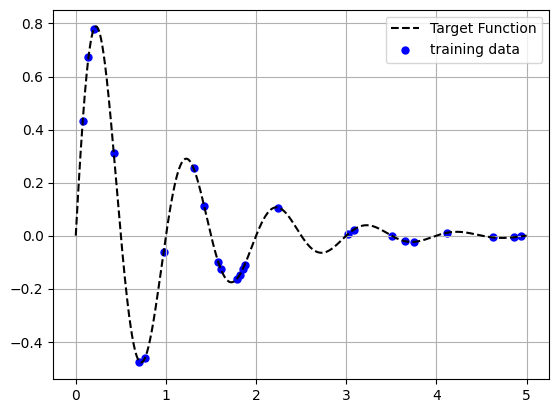

In [4]:
N = 25
Xtrain = np.random.uniform(0,5,N).reshape(-1,1)
Xtest = np.linspace(0,5,1000).reshape(-1,1)
Ytrain = (np.sin(2*math.pi*Xtrain)*np.exp(-Xtrain)).ravel()
Ytest = (np.sin(2*math.pi*Xtest)*np.exp(-Xtest)).ravel()

plt.figure()
plt.plot(Xtest.ravel(), Ytest, linestyle = 'dashed', color = 'black', label = "Target Function")
plt.scatter(Xtrain.ravel(), Ytrain, s = 25.0, c = 'blue', label = 'training data')
plt.grid()
plt.legend()

In [54]:
M = 11
p = {
    'noise_var':1e-6, 
    'Z':np.linspace(0.0,5.0, M, dtype = np.float64).reshape(1,-1), 
    'mu':np.ones(M, dtype = np.float64),
    'u_Sigma_cholesky':np.tril(np.random.randn(M,M)),
    'p_Sigma_cholesky':np.eye(M, dtype = np.float64)*5.0, # The variance of the prior p(u)
    'kernel_params':np.array([1.0], dtype = np.float64)
}

def likelihood_monte_carlo(Z, X, y, Phi, Q, epsilon_sample, noise_var, s=jnp.array([1.0]), Nmc=50):
    Kxu = K(X.reshape(1,-1), Z, rbf, s)

    F_mean = Kxu @ Phi
    F_var = (K(X.reshape(1,-1),X.reshape(1,-1), rbf, s) - Kxu @ Q @ Kxu.T).ravel()
    
    F_samples = F_mean + F_var @ epsilon_sample

    sq_errors = (y*np.ones(Nmc) - F_samples)**2 

    return -np.mean(sq_errors) / (2 * noise_var) 

def elbo(p, Xtrain, Ytrain, epsilon_sample, jitter = 1e-6, Nmc = 50):
    # Putting constraints on parameters 
    Z = p['Z']
    noise_var = jnp.log1p(jnp.exp(p['noise_var'])) # Keeping noise variance positive 
    Sigma_u = p['u_Sigma_cholesky'] @ p['u_Sigma_cholesky'] # Keeping sigma SPD 
    Sigma_p = p['p_Sigma_cholesky'] @ p['p_Sigma_cholesky'] # Keeping sigma SPD 
    s = jnp.abs(p['kernel_params'])

    N = Xtrain.shape[0] # Getting the number of training data points 

    Kuu = K(Z, Z, rbf, p['kernel_params'])

    L = jnp.linalg.cholesky(Kuu + jitter * jnp.eye(Kuu.shape[0]))
    Kuu_inv = jax.scipy.linalg.cho_solve((L, True), jnp.eye(L.shape[0]))

    Phi = jax.scipy.linalg.cho_solve((L, True), p['mu'])
    Q = Kuu_inv @ (Kuu - Sigma_u) @ Kuu_inv



    full_likelihood  = 0.0 
    for i in range(N):
        full_likelihood += likelihood_monte_carlo(Z, Xtrain[i,:], Ytrain[i], Phi, Q, epsilon_sample, s = s, noise_var = noise_var, Nmc = Nmc)
    
    full_likelihood -= N * jnp.log(2*math.pi * noise_var) / 2

    KL_divergence = kl_divergence_gaussians(p['mu'], Sigma_u, jnp.zeros_like(p['mu']), Kuu + jitter * jnp.eye(Kuu.shape[0]))

    return full_likelihood - KL_divergence


Nmc = 10 # Number of monte-carlo samples
epsilon_sample = jnp.array(np.random.multivariate_normal(np.zeros(1), np.eye(1), size=(Nmc)).T)

# Getting initial loss
initial_loss = elbo(p, Xtrain, Ytrain, epsilon_sample, Nmc = Nmc)
print("Intial Loss: %.5e" % (initial_loss))

Intial Loss: -6.39049e+02


In [77]:
# Learning Rate 
lr = 1e-5
max_iter = 100
best_loss = -1e99


In [80]:
# Using the Iterator
iterator = tqdm(range(max_iter))

for iter in iterator:
    # Random batching 
    indices = np.random.choice(Xtrain.shape[0], size=N, replace=False)
    # Computing and displaying the loss at each iteration 
    this_loss = elbo(p, Xtrain[indices,:], Ytrain[indices], epsilon_sample, Nmc = Nmc)
    iterator.set_postfix_str("Current Loss: %.5e"  % (this_loss))

    if this_loss > best_loss:
        best_loss = this_loss 
        best_params = copy(p)
    
    # Computing a new gradient function and computing the gradient 
    grad_func = jax.grad(lambda p: elbo(p, Xtrain, Ytrain, epsilon_sample, Nmc = Nmc))
    grads = grad_func(p)

    # Creating trial parameters 
    trial_p = copy(p)
    trial_p['Z']  +=  lr * grads['Z']
    trial_p['mu'] += lr * grads['mu']
    trial_p['u_Sigma_cholesky'] += lr * jnp.tril(grads['u_Sigma_cholesky'])
    trial_p['Z'] = jnp.clip(trial_p['Z'], 0.0, 5.0)
    trial_p['kernel_params'] += lr * grads['kernel_params']
    

    # Updating the inducing points 
    trial_loss = elbo(trial_p, Xtrain, Ytrain, epsilon_sample, Nmc = Nmc)
    if not np.isnan(trial_loss) and trial_loss > this_loss:
        p = trial_p

    # Recomputing the random sample 
    #epsilon_sample = jnp.array(np.random.multivariate_normal(np.zeros(1), np.eye(1), size=(Nmc)).T)

100%|██████████| 100/100 [00:27<00:00,  3.61it/s, Current Loss: -2.55019e+01]


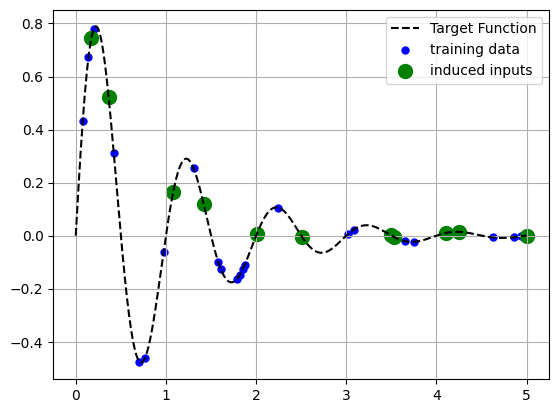

In [79]:
plt.figure()
plt.plot(Xtest.ravel(), Ytest, linestyle = 'dashed', color = 'black', label = "Target Function")
plt.scatter(Xtrain.ravel(), Ytrain, s = 25.0, c = 'blue', label = 'training data')
Z = best_params['Z']
plt.scatter(Z.ravel(), np.sin(2*math.pi*Z)*np.exp(-Z), s = 100.0, c = 'green', label = 'induced inputs')

plt.grid()
plt.legend()